In [2]:
# 动量法
%matplotlib inline
import torch
from d2l import torch as d2l

epoch 20, x1: -0.943467, x2: -0.000073


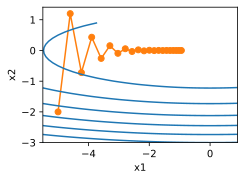

In [6]:
eta = 0.4
def f_2d(x1, x2):
    return 0.1 * x1 ** 2 + 2 * x2 ** 2 # 目标函数
def gd_2d(x1, x2, s1, s2):
    return (x1 - eta * 0.2 * x1, x2 - eta * 4 * x2, 0, 0)
# 梯度下降
d2l.show_trace_2d(f_2d, d2l.train_2d(gd_2d))

epoch 20, x1: -0.387814, x2: -1673.365109


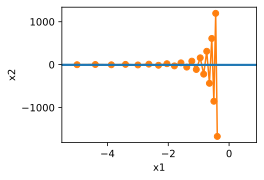

In [7]:
''' 
从构造来看，x2⽅向的梯度⽐⽔平x1⽅向的梯度⼤得多，变化也快得多。因此，我们陷⼊两难：如果选择较
⼩的学习率，我们会确保解不会在x2⽅向发散，但要承受在x1⽅向的缓慢收敛。相反，如果学习率较⾼，我
们在x1⽅向上进展很快，但在x2⽅向将会发散。下⾯的例⼦说明了即使学习率从0.4略微提⾼到0.6，也会发
⽣变化。x1⽅向上的收敛有所改善，但整体来看解的质量更差了
'''
eta = 0.6
d2l.show_trace_2d(f_2d, d2l.train_2d(gd_2d))

epoch 20, x1: 0.007188, x2: 0.002553


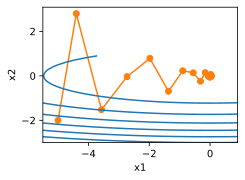

In [8]:
# 动量法
''' 
动量法（momentum）使我们能够解决上⾯描述的梯度下降问题。观察上⾯的优化轨迹，我们可能会直觉到
计算过去的平均梯度效果会很好。毕竟，在x1⽅向上，这将聚合⾮常对⻬的梯度，从⽽增加我们在每⼀步中
覆盖的距离。相反，在梯度振荡的x2⽅向，由于相互抵消了对⽅的振荡，聚合梯度将减⼩步⻓⼤⼩。使⽤vt⽽
不是梯度gt可以⽣成以下更新等式：
vt ← βvt−1 + gt,t−1,
xt ← xt−1 − ηtvt.
请注意，对于β = 0，我们恢复常规的梯度下降。在深⼊研究它的数学属性之前，让我们快速看⼀下算法在实
验中的表现如何。
'''
def momentum_2d(x1, x2, v1, v2):
    v1 = beta * v1 + 0.2 * x1
    v2 = beta * v2 + 4 * x2
    return x1 - eta * v1, x2 - eta * v2, v1, v2
eta, beta = 0.6, 0.5
d2l.show_trace_2d(f_2d, d2l.train_2d(momentum_2d))

epoch 20, x1: -0.126340, x2: -0.186632


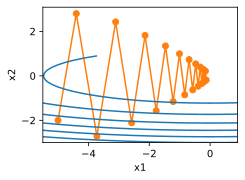

In [9]:
''' 
正如所⻅，尽管学习率与我们以前使⽤的相同，动量法仍然很好地收敛了。让我们看看当降低动量参数时会
发⽣什么。将其减半⾄β = 0.25会导致⼀条⼏乎没有收敛的轨迹。尽管如此，它⽐没有动量时解将会发散要
好得多。
-------------------------------------------------------------------------------------
请注意，我们可以将动量法与随机梯度下降，特别是⼩批量随机梯度下降结合起来。唯⼀的变化是，在这种
情况下，我们将梯度gt,t−1替换为gt。为了⽅便起⻅，我们在时间t = 0初始化v0 = 0。
'''
eta, beta = 0.6, 0.25
d2l.show_trace_2d(f_2d, d2l.train_2d(momentum_2d))

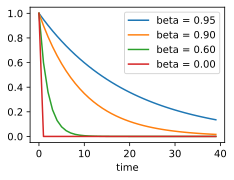

In [13]:
# 有效样本权重
'''
# 不同于在梯度下降或者随机梯度下降中取步⻓ η eta
# 我们选取步⻓ η/(1+beta)，同时处理潜在表现可能会更好的下降⽅向
# 为了说明β的不同选择的权重效果如何，请参考下⾯的图表
'''
d2l.set_figsize()
betas = [0.95, 0.9, 0.6, 0]
for beta in betas:
    x = torch.arange(40).detach().numpy()
    d2l.plt.plot(x, beta ** x, label=f'beta = {beta:.2f}')
d2l.plt.xlabel('time')
d2l.plt.legend();

In [18]:
# 从零开始实验
''' 
相⽐于⼩批量随机梯度下降，动量⽅法需要维护⼀组辅助变量，即速度。它与梯度以及优化问题的变量具有
相同的形状。在下⾯的实现中，我们称这些变量为states。
'''
def init_momentum_states(feature_dim): # 辅助变量
    v_w = torch.zeros((feature_dim, 1))
    v_b = torch.zeros(1)
    return (v_w, v_b)

def sgd_momentum(params, states, hyperparams): # 动量法
    for p, v in zip(params, states):
        with torch.no_grad():
            v[:] = hyperparams['momentum'] * v + p.grad
            p[:] -= hyperparams['lr'] * v
        p.grad.data.zero_()

loss: 0.242, 0.006 sec/epoch


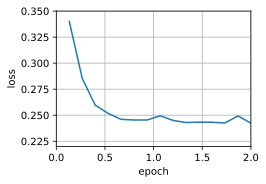

In [19]:
def train_momentum(lr, momentum, num_epochs=2):
    d2l.train_ch11(sgd_momentum, init_momentum_states(feature_dim),
                   {'lr': lr, 'momentum': momentum}, data_iter,
                   feature_dim, num_epochs) # 训练

data_iter, feature_dim = d2l.get_data_ch11(batch_size=10)
train_momentum(0.02, 0.5)

loss: 0.245, 0.006 sec/epoch


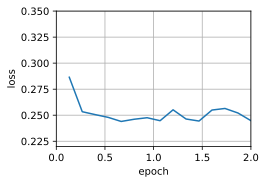

In [20]:
''' 
当我们将动量超参数momentum增加到0.9时，它相当于有效样本数量增加到
1/1−0.9 = 10。我们将学习率略微降⾄0.01，以确保可控
'''
train_momentum(0.01, 0.9)

loss: 0.244, 0.006 sec/epoch


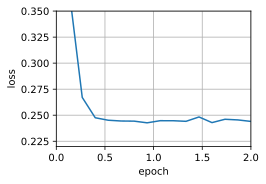

In [21]:
'降低学习率进⼀步解决了任何非平滑优化问题的困难，将其设置为0.005会产⽣良好的收敛性能'
train_momentum(0.005, 0.9)

loss: 0.245, 0.006 sec/epoch


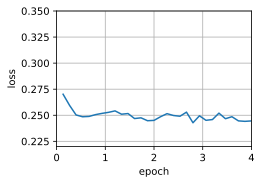

In [22]:
# 间接实现
'由于深度学习框架中的优化求解器早已构建了动量法，设置匹配参数会产⽣⾮常类似的轨迹。'
trainer = torch.optim.SGD
# 添加动量参数即可
d2l.train_concise_ch11(trainer, {'lr': 0.005, 'momentum': 0.9}, data_iter)

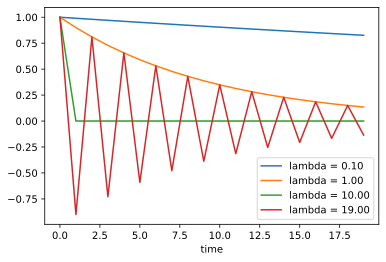

In [24]:
# 标量函数
'''
鉴于上述结果，让我们看看当我们最⼩化函数f(x) = λ/2x^2时会发⽣什么。对于梯度下降我们有

xt+1 = xt − ηλxt = (1 − ηλ)xt.

每|1 − ηλ| < 1时，这种优化以指数速度收敛，因为在t步之后我们可以得到xt = (1 − ηλ)tx0。这显⽰了在我
们将学习率η提⾼到ηλ = 1之前，收敛率最初是如何提⾼的。超过该数值之后，梯度开始发散，对于ηλ > 2⽽
⾔，优化问题将会发散。
'''
lambdas = [0.1, 1, 10, 19] # λ 取值
eta = 0.1
d2l.set_figsize((6, 4))
for lam in lambdas:
    t = torch.arange(20).detach().numpy()
    d2l.plt.plot(t, (1 - eta * lam) ** t, label=f'lambda = {lam:.2f}')
d2l.plt.xlabel('time')
d2l.plt.legend();

In [ ]:
'''
当0 < ηλ < 2 + 2β时动量收敛。与梯度下降的0 < ηλ < 2相⽐，这是更⼤范围的可⾏参
数。另外，⼀般⽽⾔较⼤值的β是可取的。
------------------------------------------------------------------------------------
⼩结
• 动量法⽤过去梯度的平均值来替换梯度，这⼤⼤加快了收敛速度
• 对于⽆噪声梯度下降和嘈杂随机梯度下降，动量法都是可取的
• 动量法可以防⽌在随机梯度下降的优化过程停滞的问题
• 由于对过去的数据进⾏了指数降权，有效梯度数为1/1−β 
• 在凸⼆次问题中，可以对动量法进⾏明确⽽详细的分析
• 动量法的实现⾮常简单，但它需要我们存储额外的状态向量（动量v）
'''